In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm.notebook import tqdm, trange
from copy import deepcopy
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import CoxTimeVaryingFitter

# own imports
from src.utils import create_nfl_field
from src.utils import load_data
from src.utils import life_expectancy

np.set_printoptions(precision=4)
pd.set_option("display.precision", 4)

In [3]:
games, plays, players, scouting, plays_with_collapse, off_cols, def_cols = (
        load_data()
    )
players_with_collapse = pd.merge(
        scouting[scouting.pff_role.isin(["Pass", "Pass Rush", "Pass Block"])][
            ["gameId", "playId", "nflId", "pff_role"]
        ],
        plays_with_collapse,
        how="right",
        on=["gameId", "playId"],
    )


100%|██████████| 8557/8557 [00:01<00:00, 4428.55it/s]


timed_pocketsizes.shape=(8557, 10)


In [4]:

off_team_cols = [
        "possessionTeam_ATL",
        "possessionTeam_BAL",
        "possessionTeam_BUF",
        "possessionTeam_CAR",
        "possessionTeam_CHI",
        "possessionTeam_CIN",
        "possessionTeam_CLE",
        "possessionTeam_DAL",
        "possessionTeam_DEN",
        "possessionTeam_DET",
        "possessionTeam_GB",
        "possessionTeam_HOU",
        "possessionTeam_IND",
        "possessionTeam_JAX",
        "possessionTeam_KC",
        "possessionTeam_LA",
        "possessionTeam_LAC",
        "possessionTeam_LV",
        "possessionTeam_MIA",
        "possessionTeam_MIN",
        "possessionTeam_NE",
        "possessionTeam_NO",
        "possessionTeam_NYG",
        "possessionTeam_NYJ",
        "possessionTeam_PHI",
        "possessionTeam_PIT",
        "possessionTeam_SEA",
        "possessionTeam_SF",
        "possessionTeam_TB",
        "possessionTeam_TEN",
        "possessionTeam_WAS",
    ]

def_team_cols = [
        "defensiveTeam_ATL",
        "defensiveTeam_BAL",
        "defensiveTeam_BUF",
        "defensiveTeam_CAR",
        "defensiveTeam_CHI",
        "defensiveTeam_CIN",
        "defensiveTeam_CLE",
        "defensiveTeam_DAL",
        "defensiveTeam_DEN",
        "defensiveTeam_DET",
        "defensiveTeam_GB",
        "defensiveTeam_HOU",
        "defensiveTeam_IND",
        "defensiveTeam_JAX",
        "defensiveTeam_KC",
        "defensiveTeam_LA",
        "defensiveTeam_LAC",
        "defensiveTeam_LV",
        "defensiveTeam_MIA",
        "defensiveTeam_MIN",
        "defensiveTeam_NE",
        "defensiveTeam_NO",
        "defensiveTeam_NYG",
        "defensiveTeam_NYJ",
        "defensiveTeam_PHI",
        "defensiveTeam_PIT",
        "defensiveTeam_SEA",
        "defensiveTeam_SF",
        "defensiveTeam_TB",
        "defensiveTeam_TEN",
        "defensiveTeam_WAS",
    ]

    ## subset of feature columns
base_feat = [
        "yardsToGo",
        "defendersInBox",
        "Cover-0",
        "Cover-1",
        "Cover-2",
        "Cover-6",
        "misc_def",
        "Quarters",  # cover 4
        "2-Man",  # "cover 5"ish
        "pff_playAction",
        "down2",
        "down3",
        "shotgun",
    ]
opt_feat = ["mean_polydists"] + [f"poly_tau_{i}" for i in range(5, 41, 5)]


In [5]:
norm_cols = list(
        set(base_feat + opt_feat).intersection(
            ["mean_polydists", "defendersInBox", "yardsToGo"]
            + [f"poly_tau_{i}" for i in range(5, 41, 5)]
        )
    )

In [6]:
plays_with_collapse["misc_def"] = plays_with_collapse.pff_passCoverage.isin(
        ["Red Zone", "Bracket", "Prevent", "Miscellaneous"]
    )

In [7]:
X = pd.get_dummies(
        plays_with_collapse[base_feat + opt_feat + ["defensiveTeam", "possessionTeam"]],
        columns=["defensiveTeam", "possessionTeam"],
    )
X[["defensiveTeam", "possessionTeam"]] = plays_with_collapse[
        ["defensiveTeam", "possessionTeam"]
    ]

In [8]:
X.head()

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_NYJ,possessionTeam_PHI,possessionTeam_PIT,possessionTeam_SEA,possessionTeam_SF,possessionTeam_TB,possessionTeam_TEN,possessionTeam_WAS,defensiveTeam,possessionTeam
0,2,6.0,False,True,False,False,False,False,False,0,...,False,False,False,False,False,True,False,False,DAL,TB
1,10,6.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL
2,6,6.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL
3,10,6.0,False,False,False,False,False,False,False,1,...,False,False,False,False,False,False,False,False,TB,DAL
4,15,7.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL


In [9]:
# X[norm_cols] = (X[norm_cols] - X[norm_cols].mean()) / X[norm_cols].std()
Y = plays_with_collapse[["survived", "surv_frame", "pass_frame"]]

In [10]:
X["time"] = Y[["surv_frame", "pass_frame"]].min(axis=1)
X["collapse_event"] = (~Y["survived"]) & (Y.surv_frame.le(Y.pass_frame))
X["pass_event"] =  (Y.surv_frame.gt(Y.pass_frame))

In [11]:
Y.shape[0] - ((Y.surv_frame.gt(Y.pass_frame)).sum() + ((~Y["survived"]) & (Y.surv_frame.le(Y.pass_frame))).sum())

np.int64(59)

In [12]:
## at this point, we have a _short_ dataset X,Y
## Now we have to figure out a way of how to build the "correct" full Dataset. 

In [13]:
X.columns

Index(['yardsToGo', 'defendersInBox', 'Cover-0', 'Cover-1', 'Cover-2',
       'Cover-6', 'misc_def', 'Quarters', '2-Man', 'pff_playAction', 'down2',
       'down3', 'shotgun', 'mean_polydists', 'poly_tau_5', 'poly_tau_10',
       'poly_tau_15', 'poly_tau_20', 'poly_tau_25', 'poly_tau_30',
       'poly_tau_35', 'poly_tau_40', 'defensiveTeam_ARI', 'defensiveTeam_ATL',
       'defensiveTeam_BAL', 'defensiveTeam_BUF', 'defensiveTeam_CAR',
       'defensiveTeam_CHI', 'defensiveTeam_CIN', 'defensiveTeam_CLE',
       'defensiveTeam_DAL', 'defensiveTeam_DEN', 'defensiveTeam_DET',
       'defensiveTeam_GB', 'defensiveTeam_HOU', 'defensiveTeam_IND',
       'defensiveTeam_JAX', 'defensiveTeam_KC', 'defensiveTeam_LA',
       'defensiveTeam_LAC', 'defensiveTeam_LV', 'defensiveTeam_MIA',
       'defensiveTeam_MIN', 'defensiveTeam_NE', 'defensiveTeam_NO',
       'defensiveTeam_NYG', 'defensiveTeam_NYJ', 'defensiveTeam_PHI',
       'defensiveTeam_PIT', 'defensiveTeam_SEA', 'defensiveTeam_SF',
       '

In [14]:
X.loc[X.collapse_event == X.pass_event, ['time', 'collapse_event', 'pass_event']]

,time,collapse_event,pass_event
220,29,False,False
733,44,False,False
1041,51,False,False
1116,43,False,False
1192,48,False,False
1254,36,False,False
1314,36,False,False
1374,31,False,False
1423,40,False,False
2086,60,False,False


In [15]:
datapoints = []
for idx in trange(len(X)): 
    d = X.iloc[idx].to_dict()
    for ti in range(5, min(d["time"]+5, 41), 5): 
        start = ti-5
        if (ti < 40) and (ti < d["time"]): 
            stop = ti 
        else: 
            stop = d["time"]
        pocket_size = d[f"poly_tau_{ti}"]
        pass_event = d["pass_event"] & ( d["time"] <= stop) 
        collapse_event = d["collapse_event"] & ( d["time"] <= stop) 
        
        dp = deepcopy(d) 
        dp["id"] = idx
        dp["start"] = start
        dp["stop"] = stop
        dp["pocket_size"] = pocket_size
        dp["pass_event"] = pass_event
        dp["collapse_event"] = collapse_event
        datapoints.append(dp)
    

  0%|          | 0/8204 [00:00<?, ?it/s]

In [16]:
tv_cols = ["id", "start", "stop", "pocket_size"]

In [17]:
tvx = pd.DataFrame(datapoints)

In [18]:
X_train, X_test = train_test_split(tvx.id.unique(), test_size=0.2)

In [19]:
tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["pass_event", "collapse_event"]].head(10)

,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,pass_event,collapse_event
0,0,0,5,4.8251,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
1,0,5,10,4.7084,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
2,0,10,15,3.8422,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
3,0,15,20,1.5468,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
4,0,20,25,0.5810,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
5,0,25,29,0.0000,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,True
6,1,0,5,4.4757,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
7,1,5,10,4.0413,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
8,1,10,15,3.6226,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
9,1,15,20,1.6771,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False


In [ ]:
col = "pass_event"
pass_ctv = CoxTimeVaryingFitter(penalizer=0.2)
pass_ctv.fit(tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+[col]], id_col="id", event_col=col, start_col="start", stop_col="stop", show_progress=True)
pass_ctv.print_summary()

Iteration 1: norm_delta = 6.50e-02, step_size = 0.9500, log_lik = -27446.64842, newton_decrement = 5.05e+01, seconds_since_start = 0.1
Iteration 2: norm_delta = 3.43e-03, step_size = 0.9500, log_lik = -27396.16315, newton_decrement = 1.42e-01, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.72e-04, step_size = 0.9500, log_lik = -27396.02187, newton_decrement = 3.57e-04, seconds_since_start = 0.1
Iteration 4: norm_delta = 9.07e-06, step_size = 1.0000, log_lik = -27396.02152, newton_decrement = 8.93e-07, seconds_since_start = 0.2
Iteration 5: norm_delta = 6.68e-12, step_size = 1.0000, log_lik = -27396.02152, newton_decrement = 5.44e-19, seconds_since_start = 0.2
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 35634 periods, 6563 subjects, 3493 events>
         event col = 'pass_event'
         penalizer = 0.5
number of subjects = 6563
 number of periods = 35634
  number of events = 3493
partial log-likelihood = -27396.02
  time fit was run = 2026-02-24 14:25:49 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
pocket_size    -0.02      0.98      0.00           -0.03           -0.01                0.97                0.99
yardsToGo      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
defendersInBox -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
Cover-0         0.07      1.07      0.05           -0.02            0.16                0.98                1.18
Cover-1         0.01      1.01      0.02           -0.02            0.05                0.98                1.05
Cover-2        -0.01      0.99      0.02           -0.05            0.03                0.95                1.03
Cover-6        -0.00      1.00      0.02           -0.05            0.04                0.95                1.04
misc_def       -0.04      0.96      0.03           -0.11            0.02                0.90                1.02
Quarters        0.02      1.02      0.02           -0.02            0.06                0.98                1.06
2-Man          -0.06      0.95      0.04           -0.14            0.03                0.87                1.03
pff_playAction -0.11      0.89      0.02           -0.14           -0.08                0.87                0.92
down2           0.03      1.03      0.01            0.00            0.06                1.00                1.06
down3          -0.03      0.97      0.02           -0.06           -0.00                0.94                1.00
shotgun         0.00      1.00      0.01           -0.02            0.03                0.98                1.03

                cmp to     z      p  -log2(p)
covariate                                    
pocket_size       0.00 -5.33 <0.005     23.25
yardsToGo         0.00 -1.69   0.09      3.45
defendersInBox    0.00 -0.82   0.41      1.27
Cover-0           0.00  1.47   0.14      2.82
Cover-1           0.00  0.90   0.37      1.44
Cover-2           0.00 -0.62   0.53      0.91
Cover-6           0.00 -0.12   0.90      0.15
misc_def          0.00 -1.44   0.15      2.74
Quarters          0.00  0.84   0.40      1.31
2-Man             0.00 -1.29   0.20      2.34
pff_playAction    0.00 -7.08 <0.005     39.29
down2             0.00  1.97   0.05      4.34
down3             0.00 -2.24   0.02      5.33
shotgun           0.00  0.23   0.82      0.29
---
Partial AIC = 54820.04
log-likelihood ratio test = 101.25 on 14 df
-log2(p) of ll-ratio test = 48.38

In [21]:
X_test

array([5063, 2698, 1998, ..., 7368, 6260, 4319], shape=(1641,))

In [22]:
tvx.loc[tvx.id.isin([2486])]

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_WAS,defensiveTeam,possessionTeam,time,collapse_event,pass_event,id,start,stop,pocket_size
13413,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,0,5,4.7007
13414,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,5,10,4.0947
13415,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,10,15,3.9046
13416,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,15,20,3.6045
13417,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,True,False,2486,20,24,0.0000


In [23]:
pred = pass_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin([2486]), tv_cols+base_feat+["pass_event"]]).values

In [24]:
pred

array([1.0092, 1.0228, 1.0271, 1.0339, 1.1193])

In [25]:
plot_pred = np.hstack([[pri]*5 for pri in pred])
np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0])

array([1.5667e-04, 3.1342e-04, 7.8405e-04, 1.2498e-03, 1.7161e-03,
       3.0042e-03, 5.7063e-03, 1.1974e-02, 2.2309e-02, 4.1685e-02,
       7.3758e-02, 1.1188e-01, 1.5608e-01, 1.9610e-01, 2.4446e-01,
       2.9845e-01, 3.6031e-01, 4.2784e-01, 4.9407e-01, 5.7306e-01,
       7.0925e-01, 8.0136e-01, 8.9098e-01, 9.9118e-01, 1.0900e+00])

In [26]:
plot_pred

array([1.0092, 1.0092, 1.0092, 1.0092, 1.0092, 1.0228, 1.0228, 1.0228,
       1.0228, 1.0228, 1.0271, 1.0271, 1.0271, 1.0271, 1.0271, 1.0339,
       1.0339, 1.0339, 1.0339, 1.0339, 1.1193, 1.1193, 1.1193, 1.1193,
       1.1193])

In [27]:
pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0]

array([1.5525e-04, 3.1056e-04, 7.7690e-04, 1.2384e-03, 1.7005e-03,
       2.9373e-03, 5.5793e-03, 1.1708e-02, 2.1812e-02, 4.0756e-02,
       7.1815e-02, 1.0893e-01, 1.5197e-01, 1.9093e-01, 2.3802e-01,
       2.8867e-01, 3.4850e-01, 4.1382e-01, 4.7788e-01, 5.5428e-01,
       6.3364e-01, 7.1593e-01, 7.9600e-01, 8.8551e-01, 9.7381e-01])

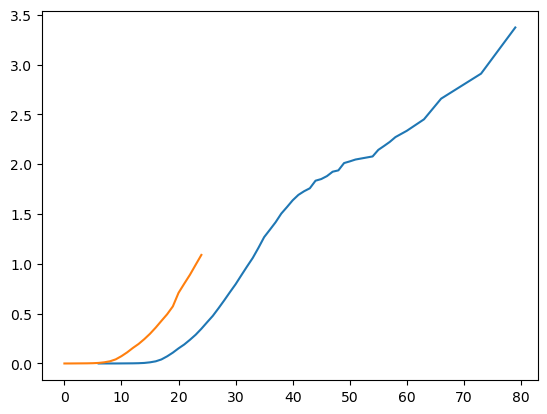

In [28]:
plt.plot(pass_ctv.baseline_cumulative_hazard_, label='baseline_cumulative_hazard')
plt.plot(np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0]), label="basline*partial")

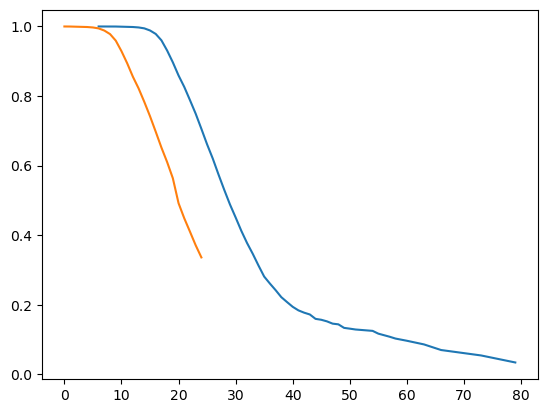

In [29]:
plt.plot(np.exp(-pass_ctv.baseline_cumulative_hazard_), label='baseline_cumulative_survival')
plt.plot(np.exp(-1*np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0])), label="basline*partial")

In [ ]:
collapse_ctv = CoxTimeVaryingFitter(penalizer=0.2)
collapse_ctv.fit(tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["collapse_event"]], id_col="id", event_col="collapse_event", start_col="start", stop_col="stop", show_progress=True)
collapse_ctv.print_summary()

Iteration 1: norm_delta = 3.05e-01, step_size = 0.9500, log_lik = -23595.68896, newton_decrement = 5.79e+02, seconds_since_start = 0.1
Iteration 2: norm_delta = 2.04e-02, step_size = 0.9500, log_lik = -23013.07688, newton_decrement = 2.56e+00, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.05e-03, step_size = 0.9500, log_lik = -23010.52135, newton_decrement = 6.76e-03, seconds_since_start = 0.1
Iteration 4: norm_delta = 5.53e-05, step_size = 1.0000, log_lik = -23010.51461, newton_decrement = 1.70e-05, seconds_since_start = 0.2
Iteration 5: norm_delta = 2.21e-10, step_size = 1.0000, log_lik = -23010.51459, newton_decrement = 2.92e-16, seconds_since_start = 0.2
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 35634 periods, 6563 subjects, 3023 events>
         event col = 'collapse_event'
         penalizer = 0.25
number of subjects = 6563
 number of periods = 35634
  number of events = 3023
partial log-likelihood = -23010.51
  time fit was run = 2026-02-24 14:25:50 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
pocket_size    -0.19      0.83      0.01           -0.20           -0.18                0.82                0.84
yardsToGo      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
defendersInBox  0.02      1.02      0.01           -0.00            0.04                1.00                1.04
Cover-0         0.21      1.24      0.06            0.09            0.34                1.09                1.40
Cover-1         0.01      1.01      0.02           -0.03            0.05                0.97                1.05
Cover-2        -0.02      0.98      0.03           -0.08            0.03                0.93                1.03
Cover-6        -0.03      0.97      0.03           -0.09            0.03                0.91                1.03
misc_def        0.01      1.01      0.04           -0.07            0.10                0.94                1.10
Quarters       -0.04      0.97      0.03           -0.09            0.02                0.91                1.02
2-Man          -0.06      0.94      0.06           -0.17            0.05                0.84                1.05
pff_playAction  0.04      1.04      0.02           -0.00            0.08                1.00                1.08
down2          -0.00      1.00      0.02           -0.04            0.04                0.96                1.04
down3           0.04      1.04      0.02            0.00            0.08                1.00                1.08
shotgun        -0.02      0.98      0.02           -0.06            0.01                0.94                1.01

                cmp to      z      p  -log2(p)
covariate                                     
pocket_size       0.00 -33.54 <0.005    816.64
yardsToGo         0.00  -1.03   0.30      1.73
defendersInBox    0.00   1.75   0.08      3.65
Cover-0           0.00   3.41 <0.005     10.59
Cover-1           0.00   0.48   0.63      0.66
Cover-2           0.00  -0.92   0.36      1.48
Cover-6           0.00  -0.99   0.32      1.64
misc_def          0.00   0.35   0.72      0.47
Quarters          0.00  -1.25   0.21      2.25
2-Man             0.00  -1.04   0.30      1.74
pff_playAction    0.00   1.84   0.07      3.94
down2             0.00  -0.03   0.97      0.04
down3             0.00   2.01   0.04      4.48
shotgun           0.00  -1.29   0.20      2.34
---
Partial AIC = 46049.03
log-likelihood ratio test = 1170.35 on 14 df
-log2(p) of ll-ratio test = 798.55

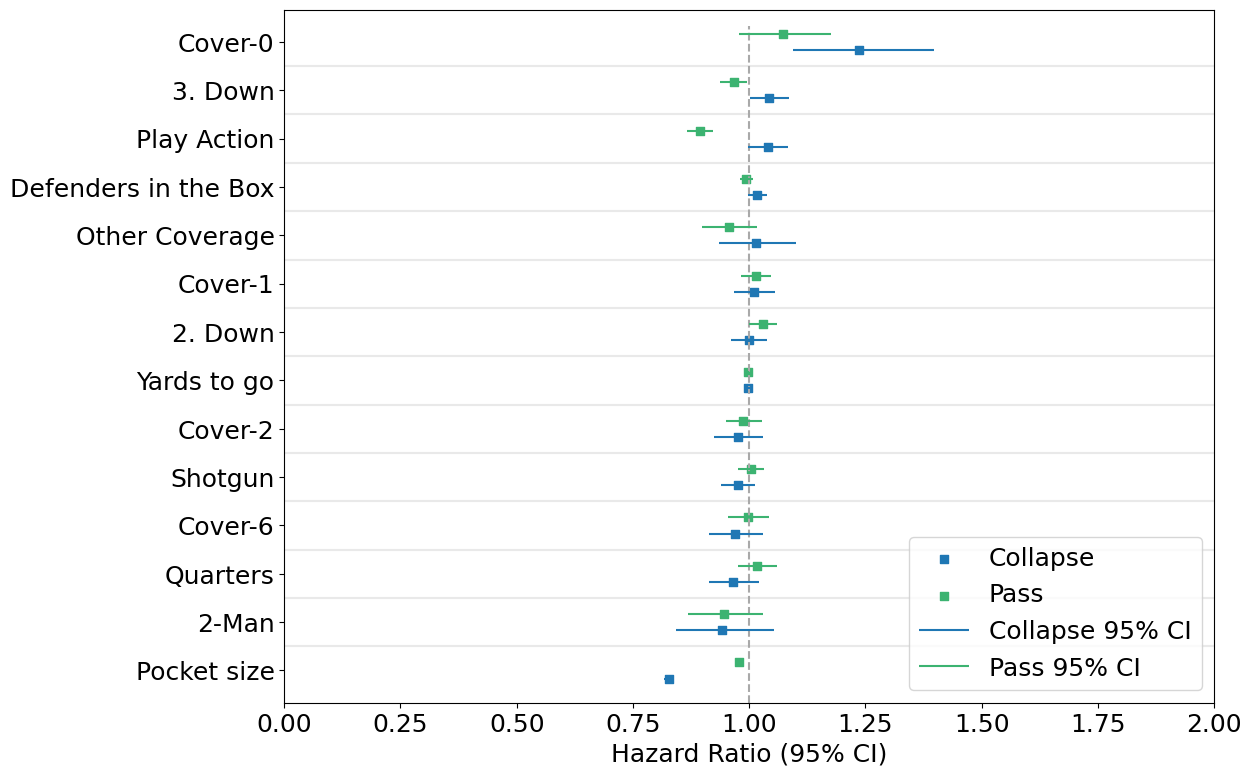

In [31]:
with plt.style.context({"font.size":18}):
    fig, ax = plt.subplots(figsize=(12,9))
    ax.vlines([1.0], ymin=-1, ymax=41, linestyles="--", color="darkgray")
    plt.xlabel("Hazard Ratio (95% CI)")

    yticklabel_dict = {
        "Cover-0":"Cover-0", 
        "Cover-1":"Cover-1", 
        "Cover-2":"Cover-2", 
        "Cover-6":"Cover-6", 
        "Quarters":"Quarters",
        "2-Man":"2-Man",
        "shotgun":"Shotgun", 
        "down3":"3. Down", 
        "down2":"2. Down", 
        "yardsToGo":"Yards to go", 
        "misc_def": "Other Coverage", 
        "pocket_size": "Pocket size", 
        "defendersInBox": "Defenders in the Box", 
        "pff_playAction":"Play Action"
    }

    hr_plot_df = pd.DataFrame({
        "collapse_hr":collapse_ctv.hazard_ratios_,
        "pass_hr":pass_ctv.hazard_ratios_,
        "collapse_lb":np.exp(collapse_ctv.confidence_intervals_["95% lower-bound"]),
        "collapse_ub":np.exp(collapse_ctv.confidence_intervals_["95% upper-bound"]),
        "pass_lb":np.exp(pass_ctv.confidence_intervals_["95% lower-bound"]),
        "pass_ub":np.exp(pass_ctv.confidence_intervals_["95% upper-bound"]),
    }).reset_index().sort_values("collapse_hr")

    y_loc = np.arange(1,43,3)
    hr_plot_df["covariate"] = hr_plot_df["covariate"].map(yticklabel_dict)

    ax.scatter(hr_plot_df["collapse_hr"].values, y_loc-0.5, marker="s", label="Collapse")
    ax.scatter(hr_plot_df["pass_hr"].values, y_loc+0.5, marker="s", color="mediumseagreen", label="Pass")

    ax.hlines(y_loc-0.5, hr_plot_df["collapse_lb"], hr_plot_df["collapse_ub"], label="Collapse 95% CI")
    ax.hlines(y_loc+0.5, hr_plot_df["pass_lb"], hr_plot_df["pass_ub"], label="Pass 95% CI", color="mediumseagreen")
    
    ax.hlines(y_loc[:-1]+1.5, xmin=0.0, xmax=4, color="darkgray", alpha=.25)

    ax.set_yticks(y_loc, hr_plot_df["covariate"].values)
    plt.xlim(0,2)
    plt.ylim(-1,42)
    plt.legend(loc="lower right")
    plt.savefig("time_vary_hr.png", dpi=600)
    plt.show()

## so we now have two models, each of which allows to estimate the hazard conditional on the pocket size
### next step is then to use the hazards to estimate the cumulative incidence conditional on the pocket size
### do we also want to predict / estimate the pocket size pre snap? 

In [32]:
tvx.loc[tvx.id.isin([X_test])]

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_WAS,defensiveTeam,possessionTeam,time,collapse_event,pass_event,id,start,stop,pocket_size


In [33]:
collapse_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin(X_test), tv_cols+base_feat+["collapse_event"]])

0       0.6786
1       0.6325
2       0.8988
3       1.5891
4       1.5640
         ...  
8899    0.6915
8900    0.7025
8901    0.7824
8902    1.0779
8903    1.6889
Length: 8904, dtype: float64

In [34]:
pass_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin(X_test), tv_cols+base_feat+["pass_event"]])

0       1.0052
1       0.9971
2       1.0384
3       1.1091
4       1.1070
         ...  
8899    0.9337
8900    0.9354
8901    0.9471
8902    0.9828
8903    1.0352
Length: 8904, dtype: float64

In [35]:
hdf = pd.concat([
    pd.Series(np.arange(100), name="t"), 
    collapse_ctv.baseline_survival_.rename(columns={"baseline survival":"baseline_collapse_survival"}), 
    collapse_ctv.baseline_cumulative_hazard_.rename(columns={"baseline hazard":"baseline_collapse_cum_hazard"}),
    pass_ctv.baseline_survival_.rename(columns={"baseline survival":"baseline_pass_survival"}), 
    pass_ctv.baseline_cumulative_hazard_.rename(columns={"baseline hazard":"baseline_pass_cum_hazard"})
    ], axis=1)

hdf['baseline_collapse_survival'] = hdf['baseline_collapse_survival'].ffill().fillna(1.0)
hdf['baseline_collapse_cum_hazard'] = hdf['baseline_collapse_cum_hazard'].ffill().fillna(0.0)

hdf['baseline_pass_survival'] = hdf['baseline_pass_survival'].ffill().fillna(1.0)
hdf['baseline_pass_cum_hazard'] = hdf['baseline_pass_cum_hazard'].ffill().fillna(0.0)

hdf['baseline_collapse_hazard'] = hdf['baseline_collapse_cum_hazard'].diff().fillna(0.0)
hdf['baseline_pass_hazard'] = hdf['baseline_pass_cum_hazard'].diff().fillna(0.0)
hdf.head(15)


,t,baseline_collapse_survival,baseline_collapse_cum_hazard,baseline_pass_survival,baseline_pass_cum_hazard,baseline_collapse_hazard,baseline_pass_hazard
0,0,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
1,1,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
2,2,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
3,3,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
4,4,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
5,5,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
6,6,0.9998,0.0002,0.9998,0.0002,0.0002,0.0002
7,7,0.9996,0.0004,0.9998,0.0002,0.0002,0.0000
8,8,0.9996,0.0004,0.9998,0.0002,0.0000,0.0000
9,9,0.9989,0.0011,0.9997,0.0003,0.0007,0.0002


<Axes: >

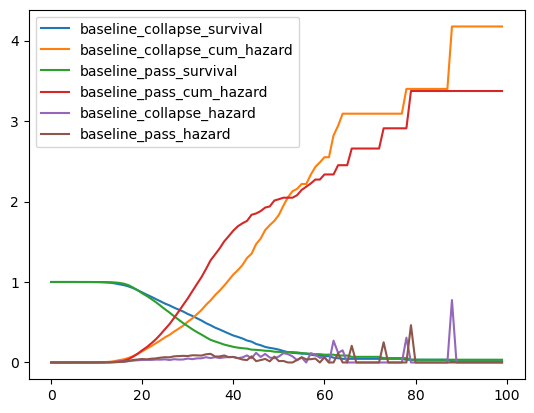

In [36]:
hdf.drop(columns=["t"]).plot()

In [149]:
pass_calib = [[] for _ in range(100)]
total_passes = 0

collapse_calib = [[] for _ in range(100)]
total_collapses = 0

for test_id in tqdm(X_train): 
    input_df = tvx.loc[tvx.id==test_id, tv_cols+base_feat+["collapse_event", "pass_event"]]
    
    pred_partial_hazard_collapse = collapse_ctv.predict_partial_hazard(input_df)
    pred_partial_hazard_collapse.index = input_df.stop

    pred_partial_hazard_pass = pass_ctv.predict_partial_hazard(input_df)
    pred_partial_hazard_pass.index = input_df.stop

    df = pd.concat([
        hdf["baseline_collapse_hazard"], 
        pred_partial_hazard_collapse.rename("partial_collapse_hazard"),
        hdf["baseline_pass_hazard"], 
        pred_partial_hazard_pass.rename("partial_pass_hazard")
        ],axis=1)

    df["partial_collapse_hazard"] = df["partial_collapse_hazard"].bfill()
    df["collapse_hazard"] = df["partial_collapse_hazard"]*df["baseline_collapse_hazard"]
    df["cum_collapse_hazard"] = df["collapse_hazard"].cumsum()

    df["partial_pass_hazard"] = df["partial_pass_hazard"].bfill()
    df["pass_hazard"] = df["partial_pass_hazard"]*df["baseline_pass_hazard"]
    df["cum_pass_hazard"] = df["pass_hazard"].cumsum()
    
    df["pp"] = 1 - np.exp(-df["pass_hazard"])
    df["pc"] = 1 - np.exp(-df["collapse_hazard"])
    
    stop_time = input_df["stop"].max()
    for vh in df.collapse_hazard.head(stop_time).values: 
        collapse_calib[min(int(vh*100), 99)].append(0)
    for vh in df.pass_hazard.head(stop_time).values: 
        pass_calib[min(int(vh*100), 99)].append(0)
    
    chzd = df[["pc", "cum_collapse_hazard"]].iloc[stop_time].to_dict()
    phzd = df[["pp", "cum_pass_hazard"]].iloc[stop_time].to_dict()

    if input_df["collapse_event"].max(): 
        collapse_calib[min(int(chzd["pc"]*100), 99)].append(1) 
        total_collapses += 1      

    if input_df["pass_event"].max(): 
        pass_calib[min(int(phzd["pp"]*100), 99)].append(1)        
        total_passes += 1
    
    # print(stop_time, collapse_happened, pass_happened)
    # print("collapse hazard@stop: ", df[["collapse_hazard", "cum_collapse_hazard"]].iloc[stop_time].to_dict())
    # does this mean, 2.93 % of times this should have collapsed here / 0.0666 percent should have died until this step? 




    # pred_partial_hazard_pass = pass_ctv.predict_partial_hazard(tvx.loc[tvx.id==test_id, tv_cols+base_feat+["pass_event"]])
    # partial hazard is grouped in 5s. 

  0%|          | 0/6563 [00:00<?, ?it/s]

In [150]:
input_df


,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,collapse_event,pass_event
6066,1147,0,5,4.4976,3,6.0,False,False,True,False,False,False,False,0,False,True,True,False,False
6067,1147,5,10,4.4097,3,6.0,False,False,True,False,False,False,False,0,False,True,True,False,False
6068,1147,10,15,4.1948,3,6.0,False,False,True,False,False,False,False,0,False,True,True,False,False
6069,1147,15,20,3.3949,3,6.0,False,False,True,False,False,False,False,0,False,True,True,False,False
6070,1147,20,25,2.4479,3,6.0,False,False,True,False,False,False,False,0,False,True,True,False,False
6071,1147,25,30,0.8157,3,6.0,False,False,True,False,False,False,False,0,False,True,True,False,False
6072,1147,30,33,0.0000,3,6.0,False,False,True,False,False,False,False,0,False,True,True,True,False


c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


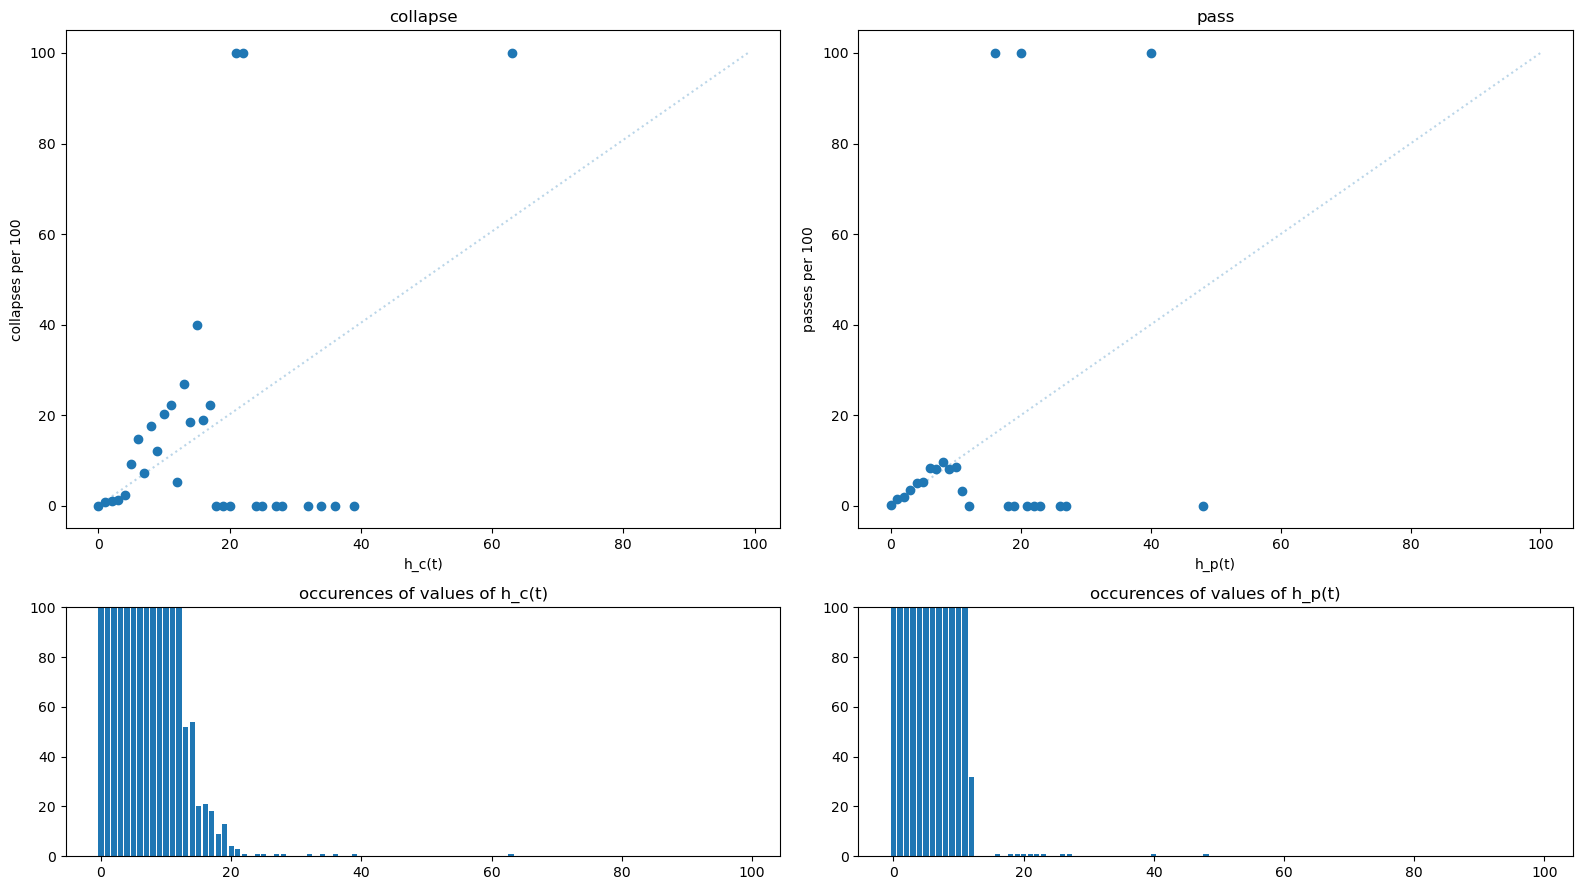

In [151]:
fig, ax = plt.subplots(2,2, figsize=(16,9), height_ratios=(2,1))
ax[0,0].plot([0,99], [0,100], alpha=.3, linestyle=":")
ax[0,0].scatter(np.arange(100),[np.mean(bucket)*100 for bucket in collapse_calib])
ax[0,0].set_title("collapse")
ax[0,0].set_xlabel("h_c(t)")
ax[0,0].set_ylabel("collapses per 100")
ax[0,1].plot([0,100], [0,100], alpha=.3, linestyle=":")
ax[0,1].scatter(np.arange(100),[np.mean(bucket)*100 for bucket in pass_calib])
ax[0,1].set_xlabel("h_p(t)")
ax[0,1].set_ylabel("passes per 100")
ax[0,1].set_title("pass")
ax[1,0].bar(np.arange(100), [len(bucket) for bucket in collapse_calib])
ax[1,0].set_title("occurences of values of h_c(t)")
ax[1,1].bar(np.arange(100), [len(bucket) for bucket in pass_calib])
ax[1,1].set_title("occurences of values of h_p(t)")
fig.tight_layout()
ax[1,0].set_ylim(0,100)
ax[1,1].set_ylim(0,100)
plt.show()


<Axes: >

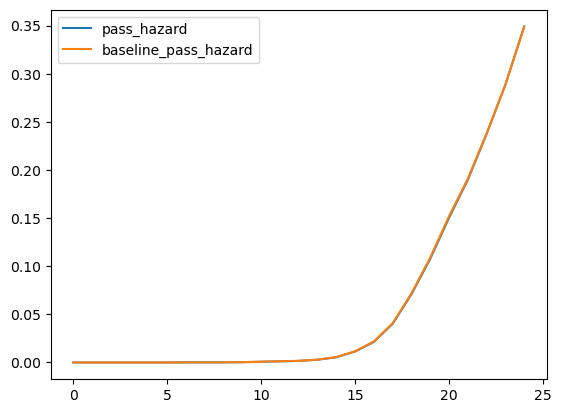

In [40]:
df[["pass_hazard", "baseline_pass_hazard"]].cumsum().head(25).plot()

In [41]:
# we have df in 5er buckets. we have collapse event bool, we have event timing. so> how large was hazard before shit hit the fan? 

In [42]:
tvx.loc[(tvx.start.eq(20)), tv_cols+base_feat+["collapse_event", "pass_event"]]

,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,collapse_event,pass_event
4,0,20,25,0.5810,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
10,1,20,23,0.0000,10,6.0,False,False,False,False,False,False,False,0,False,False,False,True,False
19,3,20,25,1.1385,10,6.0,False,False,False,False,False,False,False,1,False,False,False,False,False
37,7,20,25,0.9338,10,6.0,False,False,False,True,False,False,False,0,True,False,True,False,True
42,8,20,25,1.4281,10,6.0,False,False,False,False,False,False,False,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44506,8198,20,25,3.4918,20,4.0,False,False,True,False,False,False,False,0,True,False,True,False,False
44513,8199,20,25,3.3290,15,4.0,False,False,True,False,False,False,False,0,True,False,True,False,True
44518,8200,20,25,1.4342,8,4.0,False,False,False,False,True,False,False,0,False,True,True,False,False
44530,8202,20,25,0.5840,7,6.0,False,False,True,False,False,False,False,0,True,False,True,False,False


In [153]:
bucket_size=2
calib_c_dict = {}
calib_p_dict = {}
calib_cifc_dict = {}
calib_cifp_dict = {}
calib_cif_surv_dict = {}
calib_surv_dict = {}

for tau_landmark in range(15,31,5): 
    tau_window_size = 5
    total_passes = 0

    collapse_calib = [[] for _ in range(100//bucket_size)]
    pass_calib = [[] for _ in range(100//bucket_size)]
    cifc_calib = [[] for _ in range(100//bucket_size)]
    cifp_calib = [[] for _ in range(100//bucket_size)]
    surv_calib = [[] for _ in range(100//bucket_size)]
    cif_surv_calib = [[] for _ in range(100//bucket_size)]
    
    
    total_collapses = 0
    total_neither = 0


    for test_id in tqdm(X_train): 
        input_df2 = tvx.loc[(tvx.id==test_id) & (tvx.start.between(tau_landmark, tau_landmark+tau_window_size-1)), tv_cols+base_feat+["collapse_event", "pass_event"]]
        if len(input_df2) < 1: 
            continue
        input_df = tvx.loc[(tvx.id==test_id) & (tvx.start.between(tau_landmark-5, tau_landmark+tau_window_size-1)), tv_cols+base_feat+["collapse_event", "pass_event"]]
        
        pred_partial_hazard_collapse = collapse_ctv.predict_partial_hazard(input_df.drop(columns=["pass_event"]))
        pred_partial_hazard_collapse.index = input_df.stop

        pred_partial_hazard_pass = pass_ctv.predict_partial_hazard(input_df.drop(columns=["collapse_event"]))
        pred_partial_hazard_pass.index = input_df.stop

        df = pd.concat([
            hdf["baseline_collapse_hazard"], 
            pred_partial_hazard_collapse.rename("partial_collapse_hazard"),
            hdf["baseline_pass_hazard"], 
            pred_partial_hazard_pass.rename("partial_pass_hazard")
            ],axis=1)
        
        #compute hazards
        df["partial_collapse_hazard"] = df["partial_collapse_hazard"].ffill().fillna(0.0)
        df["collapse_hazard"] = df["partial_collapse_hazard"] * df["baseline_collapse_hazard"]
        df["cum_collapse_hazard"] = df["collapse_hazard"].cumsum()

        df["partial_pass_hazard"] = df["partial_pass_hazard"].ffill().fillna(0.0)
        df["pass_hazard"] = df["partial_pass_hazard"] * df["baseline_pass_hazard"]
        df["cum_pass_hazard"] = df["pass_hazard"].cumsum()
        
        stop_time = input_df["stop"].max()
        
        df["cum_hazard_agg"] = df["cum_pass_hazard"] + df["cum_collapse_hazard"]
        df["hazard_agg"] = df["pass_hazard"] + df["collapse_hazard"]
        
        
        df["agg_survival"] = np.exp(-(df["cum_hazard_agg"]).shift(periods=1, fill_value=1.0))
        
        # cif_stuff? 
        
        df["i_c"] = (df["agg_survival"] + (1 - df["agg_survival"].iat[tau_landmark])) * (1-np.exp(-df["hazard_agg"]))*df["collapse_hazard"]/(df["hazard_agg"]+1e-9)
        df["i_p"] = (df["agg_survival"] + (1 - df["agg_survival"].iat[tau_landmark])) * (1-np.exp(-df["hazard_agg"]))*df["pass_hazard"]/(df["hazard_agg"]+1e-9)
        
        # surv = (1 - cif_p - cif_c)
        
        # add 1 if collapsed        
        preds = df.iloc[tau_landmark:min(tau_landmark+tau_window_size, stop_time+1)][["pass_hazard", "collapse_hazard", "i_c", "i_p"]].sum().to_dict()
        # the fact that the survival is also scuffed suggests, that the pass hazard may be somehow wrong. 
        surv = df["agg_survival"].iat[stop_time+1] - df["agg_survival"].iat[tau_landmark]
        surv_idx = min(int(surv*100), 99)//bucket_size
        
        cif_surv = 1 - preds["i_c"] - preds["i_p"]
        cif_surv_idx = min(int(cif_surv*100), 99)//bucket_size
        
        collapse_rate = min(int((1-np.exp(-preds["collapse_hazard"]))*100), 99)//bucket_size
        pass_rate = min(int((1-np.exp(-preds["pass_hazard"]))*100), 99)//bucket_size
        
        if input_df["collapse_event"].max(): 
            collapse_calib[collapse_rate].append(1) 
            pass_calib[pass_rate].append(0)
            
            cifc_calib[min(int(preds["i_c"]*100), 99)//bucket_size].append(1)
            cifp_calib[min(int(preds["i_p"]*100), 99)//bucket_size].append(0)
            
            surv_calib[surv_idx].append(0)
            cif_surv_calib[cif_surv_idx].append(0)
            total_collapses += 1
        elif input_df["pass_event"].max(): 
            collapse_calib[collapse_rate].append(0) 
            pass_calib[pass_rate].append(1)
            
            cifc_calib[min(int(preds["i_c"]*100), 99)//bucket_size].append(0)
            cifp_calib[min(int(preds["i_p"]*100), 99)//bucket_size].append(1)
            
            surv_calib[surv_idx].append(0)
            cif_surv_calib[cif_surv_idx].append(0)
            total_passes += 1
        else: 
            collapse_calib[collapse_rate].append(0) 
            pass_calib[pass_rate].append(0)
            
            cifc_calib[min(int(preds["i_c"]*100), 99)//bucket_size].append(0)
            cifp_calib[min(int(preds["i_p"]*100), 99)//bucket_size].append(0)
            surv_calib[surv_idx].append(1)
            cif_surv_calib[cif_surv_idx].append(1)
            total_neither += 1
        
        
        calib_c_dict[tau_landmark] = collapse_calib
        calib_p_dict[tau_landmark] = pass_calib
        calib_cifc_dict[tau_landmark] = cifc_calib
        calib_cifp_dict[tau_landmark] = cifp_calib
        calib_surv_dict[tau_landmark] = surv_calib
        calib_cif_surv_dict[tau_landmark] = cif_surv_calib
    print(f"{total_collapses=}, {total_passes=}, {total_neither=}")

  0%|          | 0/6563 [00:00<?, ?it/s]

total_collapses=715, total_passes=807, total_neither=4790


  0%|          | 0/6563 [00:00<?, ?it/s]

total_collapses=877, total_passes=1045, total_neither=2868


  0%|          | 0/6563 [00:00<?, ?it/s]

total_collapses=569, total_passes=864, total_neither=1434


  0%|          | 0/6563 [00:00<?, ?it/s]

total_collapses=370, total_passes=489, total_neither=571


In [154]:
df.iloc[15:25]

,baseline_collapse_hazard,partial_collapse_hazard,baseline_pass_hazard,partial_pass_hazard,collapse_hazard,cum_collapse_hazard,pass_hazard,cum_pass_hazard,cum_hazard_agg,hazard_agg,agg_survival,i_c,i_p
15,0.0119,0.0,0.0061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16,0.0103,0.0,0.0101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17,0.0171,0.0,0.0189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18,0.0227,0.0,0.0311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19,0.0276,0.0,0.0371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20,0.0316,0.0,0.0430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21,0.0329,0.0,0.0390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22,0.0316,0.0,0.0471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23,0.0356,0.0,0.0507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24,0.0353,0.0,0.0598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [155]:
df.iloc[tau_landmark:min(tau_landmark+tau_window_size, stop_time+1)][["pass_hazard", "collapse_hazard", "i_c", "i_p"]]

,pass_hazard,collapse_hazard,i_c,i_p
30,0.0840,0.0742,0.0686,0.0777
31,0.0939,0.0624,0.0494,0.0742
32,0.0926,0.0773,0.0519,0.0622
33,0.0916,0.0919,0.0517,0.0515


In [156]:
stop_time

33

In [157]:
preds

{'pass_hazard': 0.3619647957162485,
 'collapse_hazard': 0.3058308278243941,
 'i_c': 0.2216111906275241,
 'i_p': 0.2655509861127254}

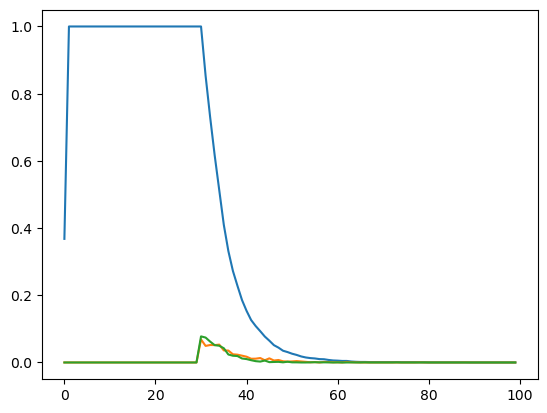

In [158]:
plt.plot(df.agg_survival)
plt.plot(df.i_c)
plt.plot(df.i_p)

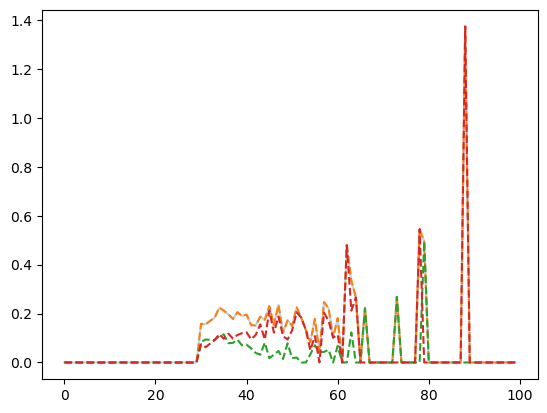

In [159]:
plt.plot(df[["hazard_agg"]], alpha=.3)
plt.plot(df["pass_hazard"]+df["collapse_hazard"], linestyle="--")
plt.plot(df["pass_hazard"], linestyle="--")
plt.plot(df["collapse_hazard"], linestyle="--")
plt.show()

In [160]:
input_df

,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,collapse_event,pass_event
6071,1147,25,30,0.8157,3,6.0,False,False,True,False,False,False,False,0,False,True,True,False,False
6072,1147,30,33,0.0000,3,6.0,False,False,True,False,False,False,False,0,False,True,True,True,False


In [161]:
preds

{'pass_hazard': 0.3619647957162485,
 'collapse_hazard': 0.3058308278243941,
 'i_c': 0.2216111906275241,
 'i_p': 0.2655509861127254}

In [162]:
[[np.mean(b), len(b)] for b in  calib_p_dict[20]]

c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[[np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(0.3404255319148936), 94],
 [np.float64(0.5211726384364821), 307],
 [np.float64(0.42424242424242425), 66],
 [np.float64(0.5634674922600619), 323],
 [np.float64(0.4782608695652174), 69],
 [np.float64(0.573943661971831), 284],
 [np.float64(0.05493133583021224), 801],
 [np.float64(0.11451706188548294), 1729],
 [np.float64(0.1830601092896175), 1098],
 [np.float64(0.21052631578947367), 19],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 

<Axes: >

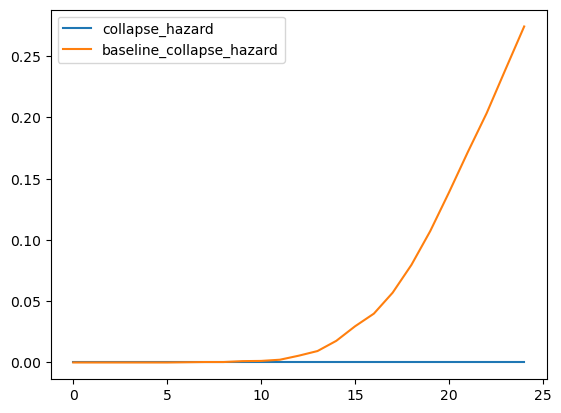

In [163]:
df[["collapse_hazard", "baseline_collapse_hazard"]].cumsum().head(25).plot()

In [164]:
[[np.mean(b), len(b)] for b in  calib_c_dict[20]]


c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[[np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(0.0), 22],
 [np.float64(0.0), 105],
 [np.float64(0.10802469135802469), 324],
 [np.float64(0.23086574654956085), 797],
 [np.float64(0.08485499462943072), 931],
 [np.float64(0.18992654774396642), 953],
 [np.float64(0.18683001531393567), 653],
 [np.float64(0.2950108459869848), 461],
 [np.float64(0.2168284789644013), 309],
 [np.float64(0.27439024390243905), 164],
 [np.float64(0.39344262295081966), 61],
 [np.float64(0.2857142857142857), 7],
 [np.float64(0.0), 1],
 [np.float64(1.0), 2],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan), 0],
 [np.float64(nan),

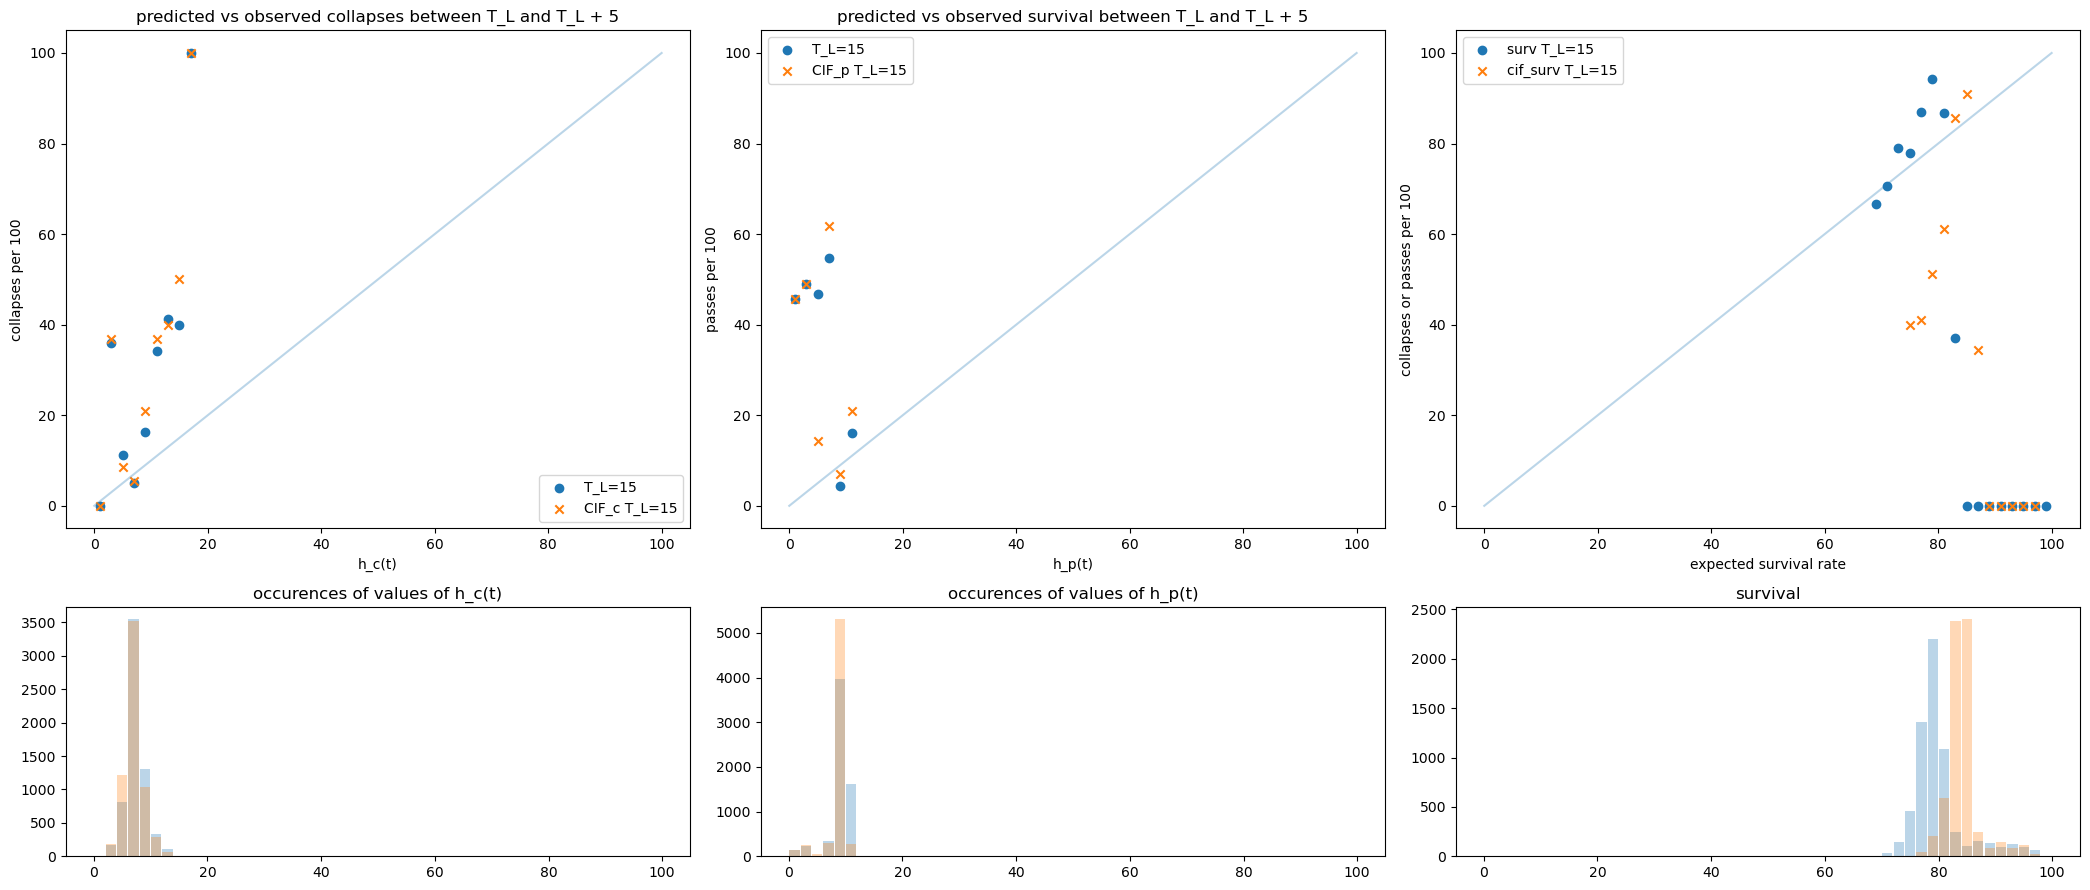

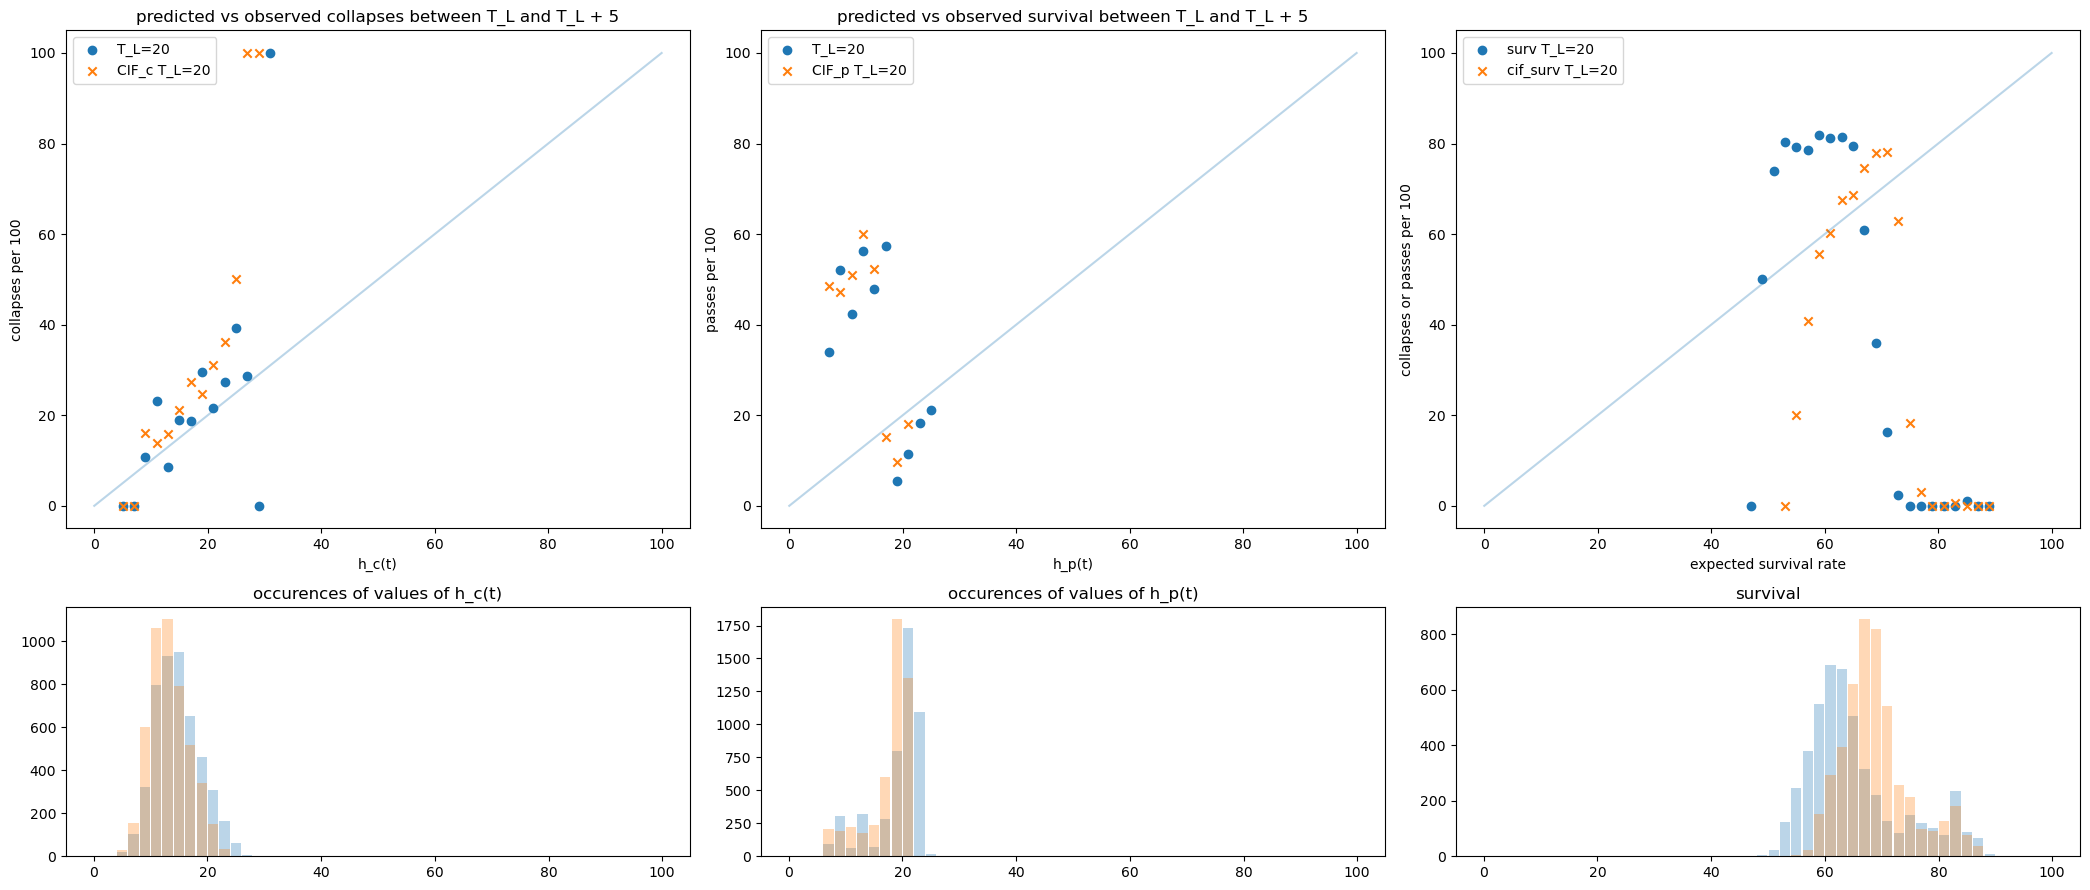

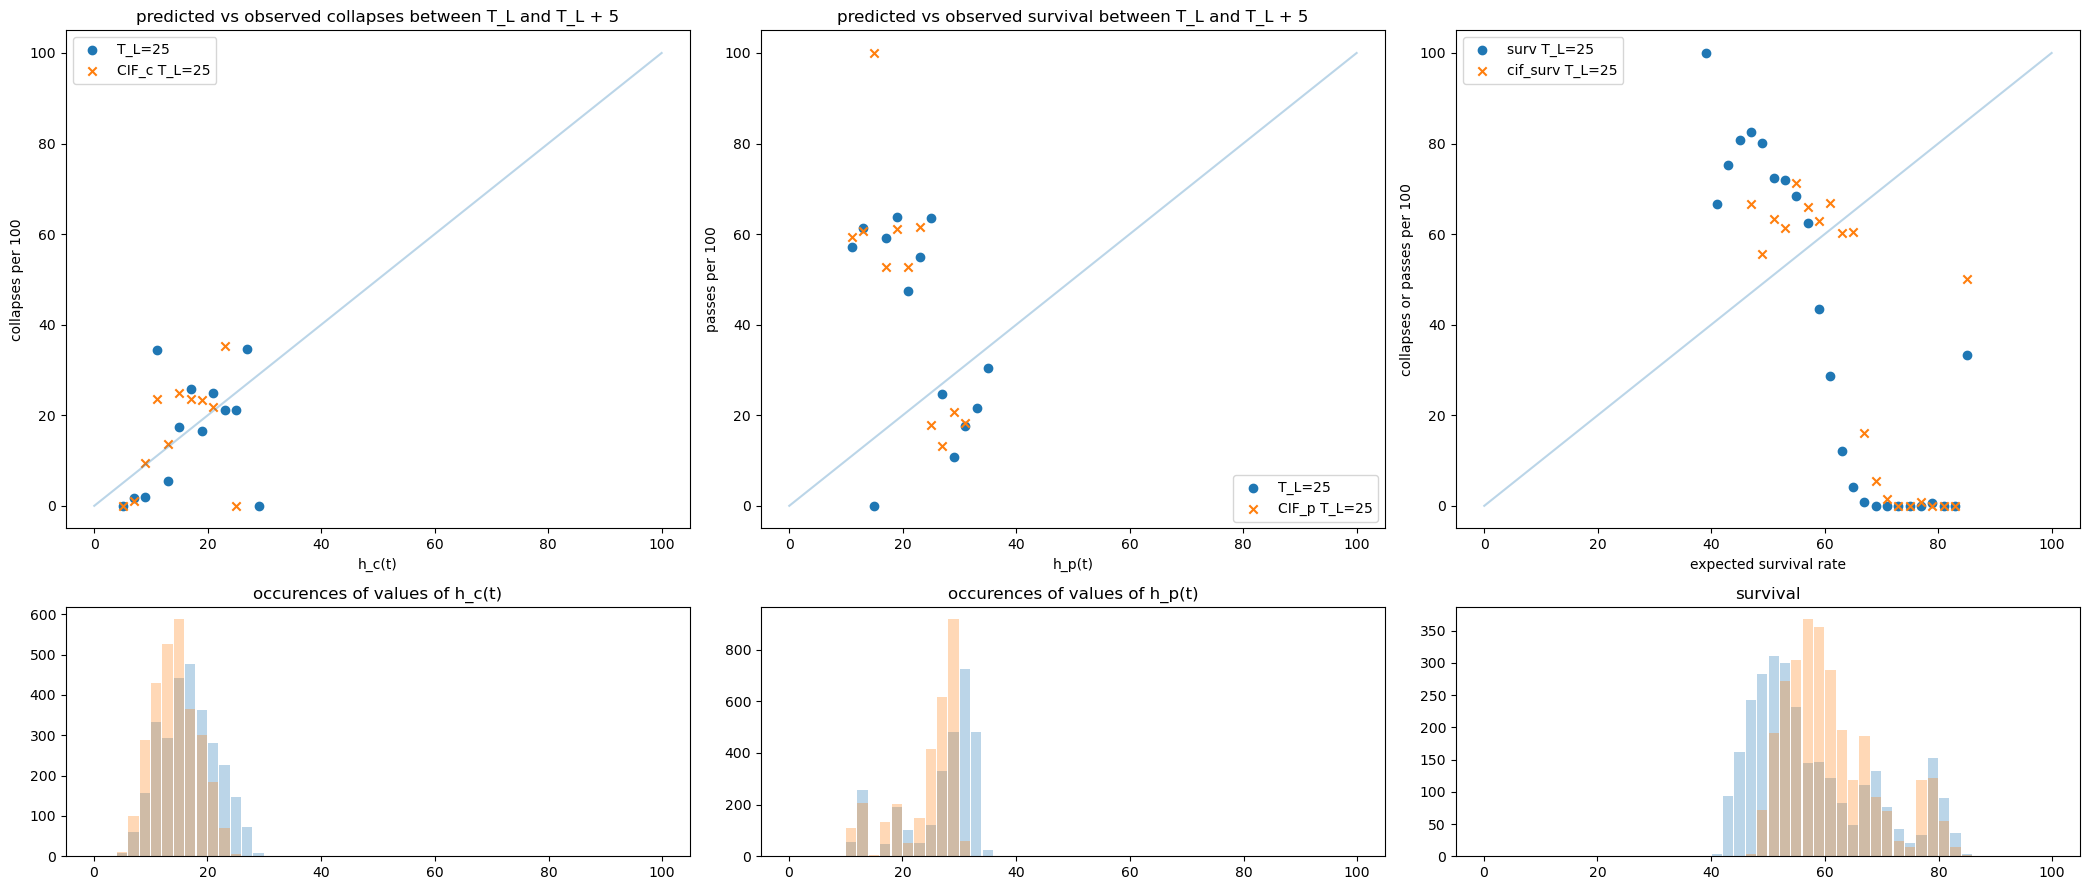

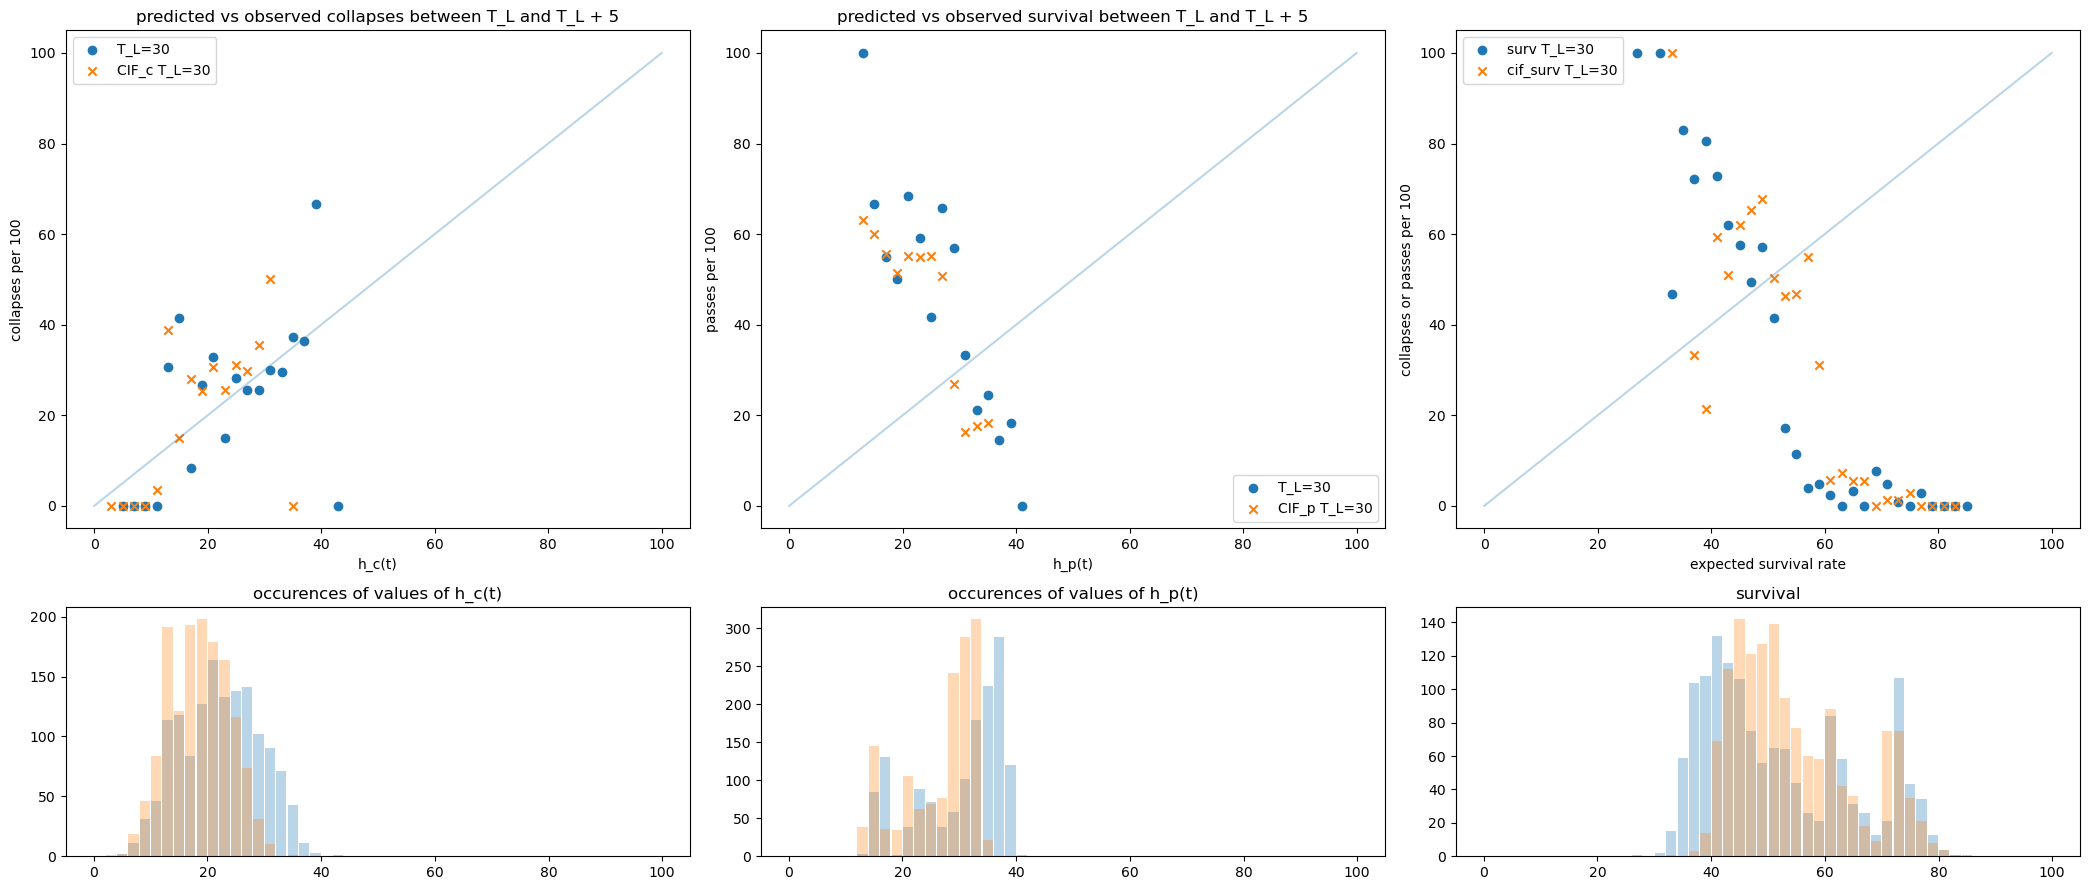

In [165]:

for tau_landmark in range(15,30+1, 5): 
    fig, ax = plt.subplots(2,3, figsize=(21,9), height_ratios=(2,1))
    ax[0,0].plot([0,100], [0,100], alpha=.3)
    ax[0,1].plot([0,100], [0,100], alpha=.3)
    ax[0,2].plot([0,100], [0,100], alpha=.3)
    x = np.arange(0,100, bucket_size)+bucket_size/2
    
    ax[0,0].scatter(x, [np.mean(bucket)*100 for bucket in calib_c_dict[tau_landmark]], label=f"T_L={tau_landmark}")
    ax[0,1].scatter(x, [np.mean(bucket)*100 for bucket in calib_p_dict[tau_landmark]], label=f"T_L={tau_landmark}")
    ax[1,0].bar(x, [len(bucket) for bucket in calib_c_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)
    ax[1,1].bar(x, [len(bucket) for bucket in calib_p_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)

    ax[0,0].scatter(x, [np.mean(bucket)*100 for bucket in calib_cifc_dict[tau_landmark]], marker="x", label=f"CIF_c T_L={tau_landmark}")
    ax[0,1].scatter(x, [np.mean(bucket)*100 for bucket in calib_cifp_dict[tau_landmark]], marker="x", label=f"CIF_p T_L={tau_landmark}")
    ax[1,0].bar(x, [len(bucket) for bucket in calib_cifc_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)
    ax[1,1].bar(x, [len(bucket) for bucket in calib_cifp_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)

    ax[0,2].scatter(x, [np.mean(bucket)*100 for bucket in calib_surv_dict[tau_landmark]], label=f"surv T_L={tau_landmark}")
    ax[1,2].bar(x, [len(bucket) for bucket in calib_surv_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)
    ax[0,2].scatter(x, [np.mean(bucket)*100 for bucket in calib_cif_surv_dict[tau_landmark]], marker="x", label=f"cif_surv T_L={tau_landmark}")
    ax[1,2].bar(x, [len(bucket) for bucket in calib_cif_surv_dict[tau_landmark]], label=tau_landmark, width = bucket_size*0.9, alpha=.3)

    ax[0,0].set_title("predicted vs observed collapses between T_L and T_L + 5")
    ax[0,1].set_title("predicted vs observed passes between T_L and T_L + 5")
    ax[0,1].set_title("predicted vs observed survival between T_L and T_L + 5")
    ax[0,0].set_xlabel("h_c(t)")
    ax[0,1].set_xlabel("h_p(t)")
    ax[0,2].set_xlabel("expected survival rate")
    ax[0,0].set_ylabel("collapses per 100")
    ax[0,1].set_ylabel("passes per 100")
    ax[0,2].set_ylabel("collapses or passes per 100")
    ax[1,0].set_title("occurences of values of h_c(t)")
    ax[1,1].set_title("occurences of values of h_p(t)")
    ax[1,2].set_title("survival")
    fig.tight_layout()
    # ax[1,0].set_ylim(0,100)
    # ax[1,1].set_ylim(0,100)
    ax[0,0].legend()
    ax[0,1].legend()
    ax[0,2].legend()
    plt.show()

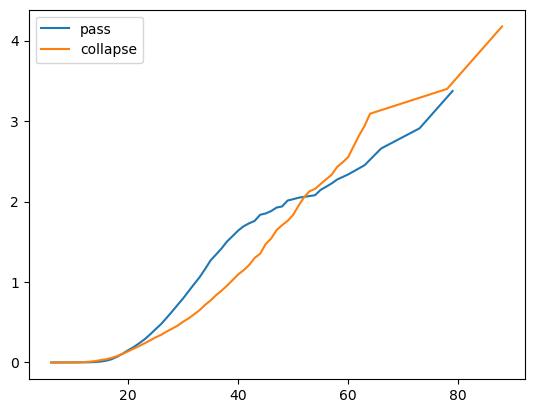

In [59]:
plt.plot(pass_ctv.baseline_cumulative_hazard_, label="pass")
plt.plot(collapse_ctv.baseline_cumulative_hazard_, label="collapse")
plt.legend()
plt.show()

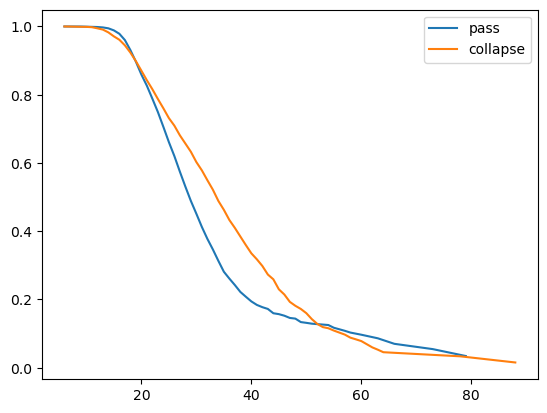

In [60]:
plt.plot(pass_ctv.baseline_survival_, label="pass")
plt.plot(collapse_ctv.baseline_survival_, label="collapse")
plt.legend()
plt.show()

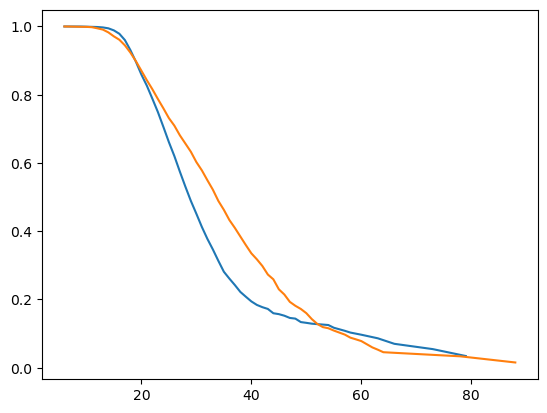

In [63]:
plt.plot(np.exp(-pass_ctv.baseline_cumulative_hazard_))
plt.plot(np.exp(-collapse_ctv.baseline_cumulative_hazard_))

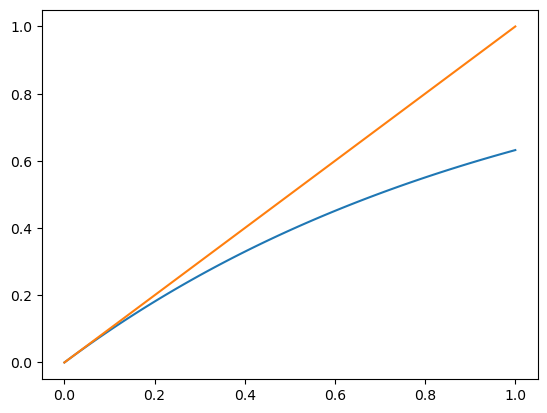

In [61]:
plt.plot(np.linspace(0,1,100), 1-np.exp(-np.linspace(0,1,100)))
plt.plot([0,1], [0,1])